In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
NUM_CLUSTERS = 4
ATTEMPTS = 20 # trade off time vs stability of clustering results
KERNEL_SIZE = 55
STOP_DIST = 66
DIR = 'processed_images'

In [3]:
def read_images(folder_path):
    images = []
    for img_name in os.listdir(folder_path):
        if img_name == '.DS_Store':
            continue
        img = read_img(folder_path, img_name)
        images.append(img)
        
    return images

def read_img(folder_path, img_name):
   return cv2.imread(f'{folder_path}/{img_name}')

In [4]:
original_images = read_images('cropped_images')
processed_images = original_images.copy()

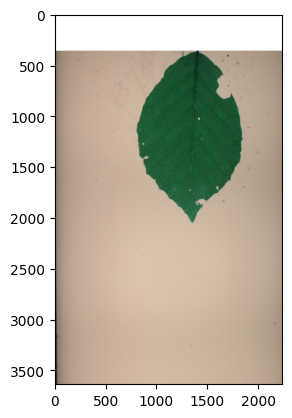

In [5]:
plt.imshow(read_images('cropped_images')[1])

In [6]:
def extract_channels(images):
    for idx, img in enumerate(images):
        img_hsv = extract_HSV_channel(img)
        images[idx] = extract_H_channel(img_hsv)

def extract_HSV_channel(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def extract_H_channel(img_hsv):
    return img_hsv[:, :, 0]

In [7]:
extract_channels(processed_images)

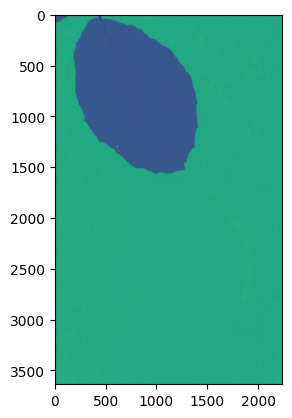

In [8]:
plt.imshow(processed_images[0])

In [9]:
def clustering_mask(img, num_clusters):
    labels_reshaped = kmeans_plusplus(img, num_clusters)
    return second_largest_cluster_mask(labels_reshaped, num_clusters)

def kmeans_plusplus(img, num_clusters): 
    pixel_values = np.float32(img.flatten())
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, ATTEMPTS, cv2.KMEANS_PP_CENTERS)
    # _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, CLUSTERING_REPEATS, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels_reshaped = labels.reshape(img.shape)
    return labels_reshaped

def second_largest_cluster_mask(labels_reshaped, num_clusters):
    masks = [cv2.inRange(labels_reshaped, cluster_id, cluster_id) for cluster_id in range(num_clusters)]
    sizes = [cv2.countNonZero(mask) for mask in masks]
    second_largest_cluster_mask = masks[sorted(zip(sizes, range(num_clusters)), reverse=True)[1][1]]

    return second_largest_cluster_mask

def largest_component_mask(mask):
        mask = np.uint8(mask)
        _, components = cv2.connectedComponents(mask, connectivity=8)
        return np.uint8(components == np.argmax(np.bincount(components.flat)[1:]) + 1) * 255

In [10]:
def largest_component_mask(mask):
    mask = np.uint8(mask)
    num_labels, labels = cv2.connectedComponents(mask, connectivity=8)
    unique, counts = np.unique(labels, return_counts=True)

    print("Number of unique labels:", num_labels) # prints the number of unique labels
    print("Counts of each label:", dict(zip(unique, counts))) # prints the counts of each label

    if num_labels <= 1:
        print("No components found in mask!")
        return mask # return the original mask if no components were found
    
    largest_component = np.argmax(counts[1:]) + 1
    largest_mask = np.uint8(labels == largest_component) * 255
    return largest_mask

In [11]:
def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [12]:
def cut_stem(masked_img, stop_distance, kernel_size):
    binary_img = gray_to_binary(masked_img)  # changed this line
    start_row = None
    end_row = None

    for row in range(binary_img.shape[0]):
        current_row = binary_img[row, :]
        non_zero_indices = np.nonzero(current_row)[0]
    
        if non_zero_indices.size > 0:
            if start_row is None:
                start_row = row
            
            pixel_distance = np.max(non_zero_indices) - np.min(non_zero_indices)
            
            if pixel_distance > stop_distance:
                end_row = row
                break

    if (start_row is not None and end_row is not None and start_row < end_row) or start_row != 0:
        stem_region = masked_img[start_row:end_row, :]  # changed this line
        blurred_stem = median_blur(stem_region, kernel_size)

        return np.vstack((masked_img[:start_row, :], blurred_stem, masked_img[end_row:, :]))  # changed this line
    else:
        print("Hi")
        return masked_img
    
def median_blur(stem_region, kernel_size):
    return cv2.medianBlur(stem_region, kernel_size)

def gray_to_binary(img):
    gray_img = rgb_to_gray(img)
    _, binary_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    return binary_img

def rgb_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [13]:
for num_clusters in range(2, NUM_CLUSTERS + 1):  
    os.makedirs(DIR, exist_ok=True)

    for idx, img in enumerate(processed_images):
        cm = clustering_mask(processed_images[idx], NUM_CLUSTERS)
        lcm = largest_component_mask(cm)
        segmented = apply_mask(original_images[idx], lcm)

        smoothed = cut_stem(segmented, STOP_DIST, KERNEL_SIZE)

        smoothed = np.where(smoothed == 0, 255, smoothed)
        # _, smoothed = cv2.threshold(smoothed, 1, 255, cv2.THRESH_BINARY)

        filename = f'{DIR}/img{idx}_{num_clusters}clusters.png'
        cv2.imwrite(filename, smoothed)


Number of unique labels: 15
Counts of each label: {0: 6768933, 1: 5299, 2: 1360279, 3: 15, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 29, 14: 3}
Number of unique labels: 80
Counts of each label: {0: 6996687, 1: 7, 2: 74, 3: 255, 4: 13, 5: 804, 6: 8, 7: 1048, 8: 1129368, 9: 93, 10: 1584, 11: 1, 12: 1, 13: 1, 14: 70, 15: 1, 16: 1, 17: 1, 18: 353, 19: 2, 20: 2, 21: 2, 22: 231, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 245, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 691, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1152, 47: 1, 48: 1, 49: 1, 50: 584, 51: 1, 52: 1, 53: 1, 54: 163, 55: 1, 56: 1, 57: 1, 58: 360, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 349, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 341, 74: 2, 75: 2, 76: 2, 77: 8, 78: 13, 79: 6}


error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/median_blur.dispatch.cpp:283: error: (-215:Assertion failed) !_src0.empty() in function 'medianBlur'
